In [2]:
from datasets import load_dataset

ds = load_dataset("frfede/twitter-sentiment")

from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

/home/meu1404/miniforge/envs/rapids-ml/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to b

In [3]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 62850
    })
})


In [4]:
import numpy as np
from datasets import DatasetDict

ds.remove_columns('sentiment')

print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 62850
    })
})


In [5]:
possible_text_cols = ["text", "tweet", "content", "sentence", "full_text"]
cols = ds["train"].column_names
text_col = next((c for c in possible_text_cols if c in cols), None)
if text_col is None:
    text_col = [c for c in cols if c not in ["label", "sentiment", "id", "idx"]][0]

tmp = ds['train'].train_test_split(test_size=0.2, seed=42)          # 80% train, 20% tạm
val_test = tmp["test"].train_test_split(test_size=0.5, seed=42)       # 10% val, 10% test
ds = DatasetDict(train=tmp["train"], validation=val_test["train"], test=val_test["test"])
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 50280
    })
    validation: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 6285
    })
    test: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 6285
    })
})


In [6]:
import re, html, unicodedata

URL_RE     = re.compile(r"(https?://\S+|www\.\S+)", flags=re.IGNORECASE)
USER_RE    = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
NUM_RE     = re.compile(r"\b\d+(?:[.,]\d+)*\b")
RT_RE      = re.compile(r"\bRT\b:?")
ELONG_RE   = re.compile(r"(.)\1{2,}")

def normalize_unicode(s: str) -> str:
    s = unicodedata.normalize("NFKC", s)
    s = html.unescape(s)
    s = "".join(ch for ch in s if ch.isprintable() or ch in "\t\n\r")
    return s

def preprocess_tweet(s: str) -> str:
    s = normalize_unicode(s)

    s = URL_RE.sub(" <URL> ", s)
    s = USER_RE.sub(" <USER> ", s)
    s = RT_RE.sub(" <RT> ", s)
    s = HASHTAG_RE.sub(r" \1 ", s)
    s = NUM_RE.sub(" <NUM> ", s)

    s = ELONG_RE.sub(r"\1\1", s)

    s = re.sub(r"\s+", " ", s).strip()
    return s

In [7]:
def preprocess_batch(batch):
    return {text_col: [preprocess_tweet(t) for t in batch[text_col]]}

ds_clean = DatasetDict({
    "train": ds["train"].map(preprocess_batch, batched=True),
    "validation": ds["validation"].map(preprocess_batch, batched=True),
    "test": ds["test"].map(preprocess_batch, batched=True),
})

ds_clean = ds_clean.filter(lambda ex: len(ex[text_col].strip()) > 0)

print(ds_clean)

Map:   0%|          | 0/50280 [00:00<?, ? examples/s]

Filter: 100%|██████████| 6285/6285 [00:00<00:00, 182674.44 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 50280
    })
    validation: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 6285
    })
    test: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 6285
    })
})


In [8]:
from collections import Counter
print("Sample BEFORE  :", ds["train"][0][text_col])
print("Sample AFTER   :", ds_clean["train"][0][text_col])

def label_counts(d): 
    c = Counter(d["label"])
    total = sum(c.values())
    return {k: f"{v} ({v/total:.1%})" for k, v in sorted(c.items())}

print("Label dist (train):", label_counts(ds_clean["train"]))
print("Label dist (valid):", label_counts(ds_clean["validation"]))
print("Label dist (test) :", label_counts(ds_clean["test"]))

Sample BEFORE  : feels like warm things
Sample AFTER   : feels like warm things
Label dist (train): {0: '16764 (33.3%)', 1: '16785 (33.4%)', 2: '16731 (33.3%)'}
Label dist (valid): {0: '2082 (33.1%)', 1: '2092 (33.3%)', 2: '2111 (33.6%)'}
Label dist (test) : {0: '2104 (33.5%)', 1: '2073 (33.0%)', 2: '2108 (33.5%)'}


In [9]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

MAX_LENGTH = 128
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def token_len(texts):
    return [len(tokenizer(t, truncation=False)["input_ids"]) for t in texts]

def tok_fn(batch):
    return tokenizer(batch[text_col], truncation=True, padding=False, max_length=MAX_LENGTH)

tok_ds = ds_clean.map(tok_fn, batched=True, remove_columns=[text_col])
data_collator = DataCollatorWithPadding(tokenizer)
num_labels = len(set(tok_ds["train"]["label"]))

print(tok_ds)
print("num_labels:", num_labels)



/home/meu1404/miniforge/envs/rapids-ml/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 6285/6285 [00:03<00:00, 1829.16 examples/s] 

DatasetDict({
    train: Dataset({
        features: ['label', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50280
    })
    validation: Dataset({
        features: ['label', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6285
    })
    test: Dataset({
        features: ['label', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6285
    })
})
num_labels: 3


In [10]:
from transformers import AutoModelForSequenceClassification
import torch

MODEL_NAME = tokenizer.name_or_path if 'tokenizer' in globals() else "bert-base-uncased"

labels_sorted = sorted(set(ds["train"]["label"]))
id2label = {i: str(i) for i in labels_sorted}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels_sorted),
    id2label=id2label,
    label2id=label2id,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("Model:", MODEL_NAME, "| num_labels:", len(labels_sorted), "| device:", device)
print("Total params (M):", round(sum(p.numel() for p in model.parameters())/1e6, 2))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: bert-base-uncased | num_labels: 3 | device: cuda
Total params (M): 109.48


In [12]:

import numpy as np, evaluate
acc = evaluate.load("accuracy"); prec = evaluate.load("precision")
rec = evaluate.load("recall");   f1 = evaluate.load("f1")

avg = "weighted"  
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "precision": prec.compute(predictions=preds, references=labels, average=avg)["precision"],
        "recall": rec.compute(predictions=preds, references=labels, average=avg)["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average=avg)["f1"],
    }


from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    num_train_epochs=3,
    warmup_ratio=0.06,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,        
    report_to="none", 
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

train_out = trainer.train()
train_out


Using the latest cached version of the module from /home/meu1404/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Sep 26 04:52:15 2025) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/meu1404/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--precision/155d3220d6cd4a6553f12da68eeb3d1f97cf431206304a4bc6e2d564c29502e9 (last modified on Fri Sep 26 04:52:17 2025) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/meu1404/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--recall/11f90e583db35601050aed380d48e83202a896976b9608432fba9244fb447f24 (last modified on Fri Sep 26 04:52:19 2025) since it couldn't be found locally at ev

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482900,0.499918,0.812888,0.812103,0.812888,0.812400
2,0.401600,0.482109,0.858075,0.858182,0.858075,0.857239
3,0.218800,0.578856,0.872872,0.872336,0.872872,0.872476


TrainOutput(global_step=18855, training_loss=0.37852897297258054, metrics={'train_runtime': 3144.9649, 'train_samples_per_second': 47.962, 'train_steps_per_second': 5.995, 'total_flos': 4116286085940000.0, 'train_loss': 0.37852897297258054, 'epoch': 3.0})

Validation: {'eval_loss': 0.5788559317588806, 'eval_accuracy': 0.8728719172633254, 'eval_precision': 0.8723359070238306, 'eval_recall': 0.8728719172633254, 'eval_f1': 0.8724762631062285, 'eval_runtime': 14.3297, 'eval_samples_per_second': 438.598, 'eval_steps_per_second': 27.425, 'epoch': 3.0}

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8875    0.9040    0.8957      2104
           1     0.8385    0.8066    0.8222      2073
           2     0.8934    0.9103    0.9018      2108

    accuracy                         0.8740      6285
   macro avg     0.8731    0.8736    0.8732      6285
weighted avg     0.8733    0.8740    0.8735      6285



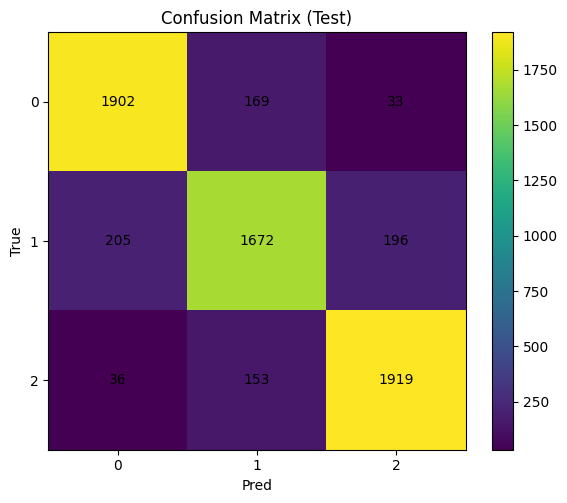

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

print("Validation:", trainer.evaluate(tok_ds["validation"]))

pred = trainer.predict(tok_ds["test"])
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=-1)

print("\nClassification report (TEST):")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in sorted(set(y_true))], digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest"); plt.title("Confusion Matrix (Test)"); plt.colorbar()
ticks = np.arange(cm.shape[0])
plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.ylabel("True")
plt.xlabel("Pred")
plt.tight_layout()
plt.show()
